<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/03-modelos/05-ensamble%2Bsvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de votación (LR+SS3+TFIDF) + SVM

En esta notebook se presetan los experimentos a partir de los datos etiquetados automáticamente a partir de las _features_ extraidas del train dataset con todas las estrategias + la construcción de un clasificador con SVM.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Pesado binario/no binario,
- Máquina de vector soporte (SVM).


## 0. Configuración de la ejecución

A continuación se genera la configuración de las estrategias que integrarán el sistema de votación para la obtención de instancias:

In [1]:
# Posibilidades : lr, ss3, tfidf
# Combinaciones:
# lr-ss3
# lr-tfidf
# ss3-tfidf
# lr-ss3-tfidf

estrategias_feature_extraction = ['lr', 'tfidf']
ACUMULTATIVO = False

# Para el sistema de votación queda fijo
CANTIDAD_INSTANCIAS = 100

Se definen algunas características fijas:

In [2]:
# El archivo de test y el train con etiquetado manual es siempre el mismo
TEST_FILE = 'correos-test-jaiio-20.csv'
TRAIN_FILE_MANUAL = 'correos-train-jaiio-80.csv'
atributos_df = ['consulta', 'dia_semana', 'semana_del_mes', 'mes', 'cuatrimestre',
                  'anio', 'hora_discretizada', 'dni_discretizado', 'legajo_discretizado',
                  'posee_legajo', 'posee_telefono', 'carrera_valor', 'proveedor_correo',
                  'cantidad_caracteres', 'proporcion_mayusculas', 'proporcion_letras',
                  'cantidad_tildes', 'cantidad_palabras', 'cantidad_palabras_cortas',
                  'proporcion_palabras_distintas', 'frecuencia_signos_puntuacion',
                  'cantidad_oraciones', 'utiliza_codigo_asignatura', 'score', 'clase_e0']

Y se generan los datos en función de la cantidad de estrategias a utilizar:

In [3]:
# Se genera el nombre del archivo de instancias a ejecutar en función de las estrategias
TRAIN_FILE_E0 = f'dataset-{estrategias_feature_extraction[0]}-200-prep.csv'
texto = f'Los dataset a utilizar son: \n\t{TRAIN_FILE_E0}'

# En caso que se realice el ensamble entre las 2 estrategias
if len(estrategias_feature_extraction)>=2:
  TRAIN_FILE_E1 = f'dataset-{estrategias_feature_extraction[1]}-200-prep.csv'
  texto = texto + f'\n\t{TRAIN_FILE_E1}'
  # Se define el if para que ante reiteradas ejecuciones de la notebook no se vuelva a insertar
  if 'clase_e1' not in atributos_df:
    atributos_df.append('clase_e1')

# En caso que se realice el ensamble entre las 3 estrategias
if len(estrategias_feature_extraction)==3:
  TRAIN_FILE_E2 = f'dataset-{estrategias_feature_extraction[2]}-200-prep.csv'
  texto = texto + f'\n\t{TRAIN_FILE_E2}' 
  # Se define el if para que ante reiteradas ejecuciones de la notebook no se vuelva a insertar
  if 'clase_e2' not in atributos_df:
    atributos_df.append('clase_e2')

print(texto)

Los dataset a utilizar son: 
	dataset-lr-200-prep.csv 
	dataset-tfidf-200-prep.csv


## 1. Instalación y Carga de librerías y funciones útiles

### 1.1 Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [4]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

### 1.2 Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [5]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df, generar_train_test_set

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [6]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

### 1.3. Carga de datos

Cargo la librería warnings para no mostrar las advertencias, pandas para el manejo de df y os para verificar la existencia de los archivos en la carga de datos. Además, cargo en memoria la URL de base de los datasets y una lista de las etiquetas de las distintas clases:

In [7]:
import warnings
import pandas as pd
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'

# Defino las clases y la cantidad a utilizar
etiquetas = get_clases()
CANTIDAD_CLASES = len(etiquetas)

Se cargan los dataframes de las estrategias seleccionadas en memoria con el preprocesamiento de los datos:

In [8]:
# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE_E0))

df_e0, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_E0, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
df_e0['consulta'] = pd.Series(preprocesar_correos(df_e0['consulta']))
test_df['consulta'] = pd.Series(preprocesar_correos(test_df['consulta']))

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(df_e0.clase.unique()), df_e0.clase.unique()))

# Me quedo con las N cantidad de instancias con mayor score por clase
if CANTIDAD_INSTANCIAS<200:
  df_e0 = df_e0.sort_values(['clase','score'], ascending=False).groupby('clase').head(CANTIDAD_INSTANCIAS).reset_index(drop=True)
  df_e0 = df_e0.sample(frac = 1)


El conjunto de entrenamiento tiene la dimensión: (3200, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


In [9]:
if len(estrategias_feature_extraction)>=2:
  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_E1))

  df_e1, test_df_e1, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_E1, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
  df_e1['consulta'] = pd.Series(preprocesar_correos(df_e1['consulta']))

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(df_e1.clase.unique()), df_e1.clase.unique()))

  # Me quedo con las N cantidad de instancias con mayor score por clase
  if CANTIDAD_INSTANCIAS<200:
    df_e1 = df_e1.sort_values(['clase','score'], ascending=False).groupby('clase').head(CANTIDAD_INSTANCIAS).reset_index(drop=True)
    df_e1 = df_e1.sample(frac = 1)


El conjunto de entrenamiento tiene la dimensión: (3200, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


Solo en el caso que decida hacer el sistema de votación entre las 3 estrategias inicializo la tercera:

In [10]:
if len(estrategias_feature_extraction)==3:

  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_E2))

  df_e2, test_df_e2, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_E2, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
  df_e2['consulta'] = pd.Series(preprocesar_correos(df_e2['consulta']))

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(df_e2.clase.unique()), df_e2.clase.unique()))

  # Me quedo con las N cantidad de instancias con mayor score por clase
  if CANTIDAD_INSTANCIAS<200:
    df_e2 = df_e2.sort_values(['clase','score'], ascending=False).groupby('clase').head(CANTIDAD_INSTANCIAS).reset_index(drop=True)
    df_e2 = df_e2.sample(frac = 1)

Verifico si voy a acumular los datos etiquetados manualmente a los de etiquetado no supervisado y en caso afirmativo los cargo en memoria:

In [11]:
if ACUMULTATIVO:
 
  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_MANUAL))

  train_df_manual, test_df_manual, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_MANUAL, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
  train_df_manual['consulta'] = pd.Series(preprocesar_correos(train_df_manual['consulta']))

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(train_df_manual.clase.unique()), train_df_manual.clase.unique()))

### 1.4 Sistema de votación entre estrategias de _feature extraction_

En primer lugar, se joinea mediante el texto de la consulta las estrategias encaradas (según sean dos o tres):

In [12]:
import pandas as pd

# Si se utiliza sólo 1 estrategia, se inicializa el df_join con solo esa
if len(estrategias_feature_extraction)==1:
  df_join = df_e0

# Si se utilizan al menos 2 estrategias, se incorpora también la 2da
if len(estrategias_feature_extraction)>=2:
  df_join = pd.merge(df_e0, df_e1, on='consulta', how='left', suffixes=(None, "_x"))

# Si están las 3 estrategias, se incorpora también la 3era
if len(estrategias_feature_extraction)==3:
  df_join = pd.merge(df_join, df_e2, on='consulta', how='left', suffixes=(None, "_y"))

Borro las instancias con faltantes y verifico el resultado la dimensionalidad del df:

In [13]:
df_join = df_join.dropna()

df_join.shape

(701, 49)

In [14]:
df_join.head()

,consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,score,clase,dia_semana_x,semana_del_mes_x,mes_x,cuatrimestre_x,anio_x,hora_discretizada_x,dni_discretizado_x,legajo_discretizado_x,posee_legajo_x,posee_telefono_x,carrera_valor_x,proveedor_correo_x,cantidad_caracteres_x,proporcion_mayusculas_x,proporcion_letras_x,cantidad_tildes_x,cantidad_palabras_x,cantidad_palabras_cortas_x,proporcion_palabras_distintas_x,frecuencia_signos_puntuacion_x,cantidad_oraciones_x,utiliza_codigo_asignatura_x,score_x,clase_x
1,inscribi dar final elementos aparece solicitud...,4,5,7,1,2016,2,7,3,1,1,25,18,226,0.0,0.787611,0,42,26,0.714286,0.022124,1,0,13.944246,Exámenes,4.0,5.0,7.0,1.0,2016.0,2.0,7.0,3.0,1.0,1.0,25.0,23.0,226.0,0.0,0.787611,0.0,42.0,26.0,0.714286,0.022124,1.0,0.0,21.248547,Exámenes
3,hola buenas tardes queria consultar cuanto per...,0,2,6,1,2017,3,6,3,1,1,5,18,238,0.0,0.810924,0,41,18,0.878049,0.021008,3,0,13.378724,Exámenes,0.0,2.0,6.0,1.0,2017.0,3.0,6.0,3.0,1.0,1.0,5.0,23.0,238.0,0.0,0.810924,0.0,41.0,18.0,0.878049,0.021008,3.0,0.0,30.215166,Exámenes
7,buen dia quisiera solicitar simultaneidad carr...,3,4,12,2,2018,1,4,2,1,1,54,18,129,0.0,0.798450,2,21,12,0.857143,0.046512,1,0,12.047333,Simultaneidad de Carreras,3.0,4.0,12.0,2.0,2018.0,1.0,4.0,2.0,1.0,1.0,54.0,23.0,129.0,0.0,0.798450,2.0,21.0,12.0,0.857143,0.046512,1.0,0.0,15.467730,Simultaneidad de Carreras
8,buen dia quisiera solicitar simultaneidad carr...,3,4,12,2,2018,1,4,2,1,1,54,18,129,0.0,0.798450,2,21,12,0.857143,0.046512,1,0,12.047333,Simultaneidad de Carreras,3.0,4.0,12.0,2.0,2018.0,1.0,4.0,2.0,1.0,1.0,54.0,23.0,129.0,0.0,0.798450,2.0,21.0,12.0,0.857143,0.046512,1.0,0.0,19.508636,Cambio de Carrera
12,buenos dias quisiera reinscribirme carrera pos...,4,4,6,1,2019,0,4,1,1,1,54,18,83,0.0,0.795181,0,12,4,1.000000,0.060241,1,0,8.897202,Cambio de Carrera,4.0,4.0,6.0,1.0,2019.0,0.0,3.0,1.0,1.0,1.0,54.0,23.0,83.0,0.0,0.795181,0.0,12.0,4.0,1.000000,0.060241,1.0,0.0,16.063390,Cambio de Carrera


Renombro las clases en función de las estrategias y me quedo sólo con las instancias en que la clase coincide:

In [15]:
if len(estrategias_feature_extraction)==3:
  df_join.rename(columns={'clase_x': 'clase_e0', 'clase_y': 'clase_e1', 'clase': 'clase_e2'}, inplace=True)
  df_join['match_clase'] = ((df_join['clase_e0'] == df_join['clase_e1']) & (df_join['clase_e1'] == df_join['clase_e2']))
elif len(estrategias_feature_extraction)==2:
  df_join.rename(columns={'clase': 'clase_e0', 'clase_x': 'clase_e1'}, inplace=True)
  df_join['match_clase'] = df_join['clase_e0'] == df_join['clase_e1']
elif len(estrategias_feature_extraction)==1:
  df_join.rename(columns={'clase': 'clase_e0'}, inplace=True)
  # Esto se hace por compatibilidad con las otras alternativas (2 y 3 estrategias)
  df_join['match_clase'] = df_join['clase_e0'] == df_join['clase_e0']
 
# Me quedo sólo con las instancias en que la clase coincide
train_df_join = df_join.query('match_clase == True').reset_index()

train_df_join.shape

(503, 51)

Me quedo solo con los atributos que me interesan (elimino duplicados):

In [16]:
train_df_join = train_df_join[atributos_df]

train_df_join.columns

Index(['consulta', 'dia_semana', 'semana_del_mes', 'mes', 'cuatrimestre',
       'anio', 'hora_discretizada', 'dni_discretizado', 'legajo_discretizado',
       'posee_legajo', 'posee_telefono', 'carrera_valor', 'proveedor_correo',
       'cantidad_caracteres', 'proporcion_mayusculas', 'proporcion_letras',
       'cantidad_tildes', 'cantidad_palabras', 'cantidad_palabras_cortas',
       'proporcion_palabras_distintas', 'frecuencia_signos_puntuacion',
       'cantidad_oraciones', 'utiliza_codigo_asignatura', 'score', 'clase_e0',
       'clase_e1'],
      dtype='object')

Me quedo sólo con una columna de clase dado que son las 3 iguales:

In [17]:
# Tomo una clase al azar, dado que coinciden las 3
train_df_join.rename(columns={'clase_e0': 'clase'}, inplace=True)

# Elimino las columnas que no necesito
if len(estrategias_feature_extraction)>=2:
  train_df_join.drop(['clase_e1'], inplace=True, axis=1)

if len(estrategias_feature_extraction)==3:
  train_df_join.drop(['clase_e2'], inplace=True, axis=1)

train_df_join.shape

(503, 25)

Me guardo la columna del score de Elasticsearch para no generar incompatibilidades:

In [18]:
score = train_df_join['score']
train_df_join.drop('score', inplace=True, axis=1)

In [19]:
if ACUMULTATIVO:
  train_df = pd.concat([train_df_manual, train_df_join], axis=0).reset_index(drop=True)
else:
  train_df = train_df_join

Muestro el dataframe resultante:

In [20]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
train_df.head()

,consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
0,inscribi dar final elementos aparece solicitud...,4,5,7,1,2016,2,7,3,1,1,25,18,226,0.0,0.787611,0,42,26,0.714286,0.022124,1,0,Exámenes
1,hola buenas tardes queria consultar cuanto per...,0,2,6,1,2017,3,6,3,1,1,5,18,238,0.0,0.810924,0,41,18,0.878049,0.021008,3,0,Exámenes
2,buen dia quisiera solicitar simultaneidad carr...,3,4,12,2,2018,1,4,2,1,1,54,18,129,0.0,0.798450,2,21,12,0.857143,0.046512,1,0,Simultaneidad de Carreras
3,buenos dias quisiera reinscribirme carrera pos...,4,4,6,1,2019,0,4,1,1,1,54,18,83,0.0,0.795181,0,12,4,1.000000,0.060241,1,0,Cambio de Carrera
4,buenas tardes necesito certificado materias cu...,0,4,6,1,2017,2,2,1,1,1,5,18,148,0.0,0.837838,0,22,9,0.909091,0.020270,2,0,Pedido de Certificados


## 2. SVM

### 2.1. Carga de librerías de procesamiento de texto

Se cargan en memoria dos funciones: _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __SVM__ y _representacion_documentos_ que genera representaciones para las _features textuales_:

In [21]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion, representacion_documentos

### 2.2 Modelo general (clasificación en las 16 clases)

En primer lugar se trabaja con un único clasificador que clasifica y testea las instancias en las 16 clases posibles.

#### 2.2.1 Definición del espacio de búsqueda

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [22]:
# Defino una lista con los esquemas de representación
estrategias_representacion = ['BINARIO', 'TFIDF', '3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
modelo = 'SVM'

# Defino los parámetros para GridSearchCV
params_svm = {'SVM__C': [0.1, 1, 10, 100], 
              'SVM__gamma': [0.01, 0.1, 1],
              'SVM__class_weight': [None, 'balanced'],
              'SVM__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
              'SVM__probability': [False]
              }

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [23]:
modelos_grid = []
representacion_grid = []
metricas_grid = []
NO_CORRIDA = True

if NO_CORRIDA:
  for estrategia in estrategias_representacion:
    # Llamo a la función que realiza el gridsearch por estrategia  
    clf_grid, X_test_g, y_test_g, metrics_grid = gridsearch_por_estrategia_representacion(train_df, test_df, estrategia, modelo, params_svm, None, atr_consulta='consulta')
    modelos_grid.append(clf_grid)
    representacion_grid.append(estrategia)
    metricas_grid.append(metrics_grid)

# ['lr', 'tfidf']
# Métricas sobre Test-Set: {'SVM__C': 10, 'SVM__class_weight': None, 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf', 'clasificador': 'SVM', 'estrategia': 'BINARIO', 'accuracy': 0.795, 'precision': 0.7967703533026114, 'recall': 0.795, 'f1_score': 0.789165448506101}
# Métricas sobre Test-Set: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf', 'clasificador': 'SVM', 'estrategia': 'TFIDF', 'accuracy': 0.78, 'precision': 0.8076557773744707, 'recall': 0.78, 'f1_score': 0.788321119391772}
# Métricas sobre Test-Set: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.835, 'precision': 0.866807546108862, 'recall': 0.835, 'f1_score': 0.842616215602101}


Estrategia de representación: BINARIO
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.7min finished


Estrategia de representación: BINARIO
Parámetros: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': False}
Accuracy Test-Set: 0.555
Métricas sobre Test-Set: {'clasificador': 'SVM', 'estrategia': 'BINARIO', 'accuracy': 0.555, 'precision': 0.7674476500451733, 'recall': 0.555, 'f1_score': 0.5966565476190476, 'mcc': 0.5253263335315733}
Estrategia de representación: TFIDF
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.8min finished


Estrategia de representación: TFIDF
Parámetros: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid', 'SVM__probability': False}
Accuracy Test-Set: 0.6
Métricas sobre Test-Set: {'clasificador': 'SVM', 'estrategia': 'TFIDF', 'accuracy': 0.6, 'precision': 0.7846485805860806, 'recall': 0.6, 'f1_score': 0.654059589633996, 'mcc': 0.5654117435979786}
Estrategia de representación: 3-4-NGRAM-CHARS
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 15.2min finished


Estrategia de representación: 3-4-NGRAM-CHARS
Parámetros: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': False}
Accuracy Test-Set: 0.615
Métricas sobre Test-Set: {'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.615, 'precision': 0.8014804975726029, 'recall': 0.615, 'f1_score': 0.6706839164402203, 'mcc': 0.5843302174667778}
Estrategia de representación: 1-2-NGRAM-WORDS
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 11.4min finished


Estrategia de representación: 1-2-NGRAM-WORDS
Parámetros: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid', 'SVM__probability': False}
Accuracy Test-Set: 0.56
Métricas sobre Test-Set: {'clasificador': 'SVM', 'estrategia': '1-2-NGRAM-WORDS', 'accuracy': 0.56, 'precision': 0.7781907528017368, 'recall': 0.56, 'f1_score': 0.6245747466487367, 'mcc': 0.5256542928102669}


A partir de los mejores hiperparámetros encontrados para cada estrategia de representación de correos, se busca cual es la estrategia que generó el mayor _accuracy_ (medida totalmente arbitraria):

In [24]:
max_accuracy = 0
for i in range(1, len(metricas_grid)):
  if metricas_grid[i]['accuracy'] > metricas_grid[max_accuracy]['accuracy']:
    max_accuracy = i

representacion_max = representacion_grid[max_accuracy]

# Se le quita el prefijo asignado a los parametricos para la búsqueda grid
params_max = params = {x.replace("SVM__", ""): v for x, v in modelos_grid[max_accuracy].best_params_.items()}

metricas_max = metricas_grid[max_accuracy]

print(f'El modelo más eficaz es {modelo} con la estrategia de representación {representacion_max} y los parámetros {params_max}')
print(f'El modelo brinda las siguientes métricas de selección: {metricas_max}')

El modelo más eficaz es SVM con la estrategia de representación 3-4-NGRAM-CHARS y los parámetros {'C': 1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'sigmoid', 'probability': False}
El modelo brinda las siguientes métricas de selección: {'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.615, 'precision': 0.8014804975726029, 'recall': 0.615, 'f1_score': 0.6706839164402203, 'mcc': 0.5843302174667778}


#### 2.2.2 Modelo generado

En función de los mejores hiperparámetros y estrategia de representación encontrados con la búsqueda Grid, ajusto el modelo para obtener las métricas.

En primer lugar genero los datos de train y test:

In [25]:
# Mejores Parámetros según GridSearchCV:
# {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'estrategia': '3-4-NGRAM-CHARS', 
#  'accuracy': 0.81, 'precision': 0.5971321956813028, 'recall': 0.553190280233687, 'f1_score': 0.5639032258154839}
# Métricas sobre Test-Set: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': True, 'clasificador': 'SVM',
# 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.835, 'precision': 0.8428499293134182, 'recall': 0.835, 'f1_score': 0.8328323317634259}

X_train, y_train, X_test, y_test = generar_train_test_set(train_df, test_df, representacion_max)

Estrategia de representación: 3-4-NGRAM-CHARS


Se entrena el modelo con los mejores hiperparámetros encontrados:

In [26]:
from sklearn.svm import SVC
clf = SVC(**params_max)

# Entreno el modelo con los parámetros
clf.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Se predicen las instancias de testeo:

In [27]:
y_pred = clf.predict(X_test)

#### 2.2.3 Métricas de selección

In [28]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.615
                                     precision    recall  f1-score   support

               Boleto Universitario       1.00      0.71      0.83        48
                  Cambio de Carrera       0.08      0.50      0.13         2
                 Cambio de Comisión       0.11      1.00      0.19         2
         Consulta por Equivalencias       1.00      1.00      1.00         3
                Consulta por Legajo       0.29      0.67      0.40         3
Consulta sobre Título Universitario       0.50      1.00      0.67         3
                           Cursadas       0.45      0.26      0.33        19
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       0.25      0.80      0.38         5
           Ingreso a la Universidad       0.89      0.52      0.65        33
             Pedido de Certificados       0.93      0.93      0.93        15
             Problemas con la Clave       0.80      0.70   

In [29]:
metrics.confusion_matrix(y_test, y_pred)

array([[34,  2,  4,  0,  0,  2,  0,  2,  2,  0,  0,  1,  1,  0,  0,  0],
       [ 0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  6,  0,  1,  0,  5,  1,  4,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  3,  1,  0,  1,  0,  1,  4,  1, 17,  1,  3,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  2,  0,  0,  0, 16,  0,  0,  0,  1],
       [ 0,  5,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  1,  0,  2,  1,  4,  0,  2,  0,  0,

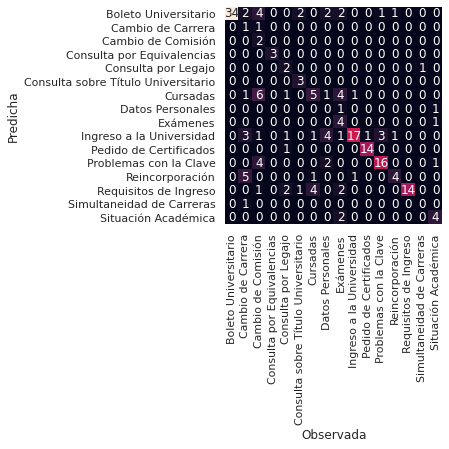

In [30]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=etiquetas, yticklabels=etiquetas)

plt.xlabel('Observada')
plt.ylabel('Predicha');

### 3. Análisis del error

A continuación se intenta entender la baja de _accuracy_ para el etiquetado a partir de TF-IDF.

Para ello, se genera el dataset de train con: <br/>
| consulta | clase | score |

In [31]:
df_train_e = train_df[['consulta', 'clase']]
df_train_e['score'] = score

Genero un dataframe con los scores promedios por clase, el accuracy por clase y el _count_:

In [32]:
df_error = df_train_e.groupby(['clase']).mean().reset_index()
# Accuracy por clase
avg_class = mat.diagonal()/mat.sum(axis=1)
df_error['accuracy'] = pd.Series(avg_class)

df_error['count'] = mat.sum(axis=1)

df_error
df_error

,clase,score,accuracy,count
0,Boleto Universitario,14.990136,0.708333,48
1,Cambio de Carrera,11.443292,0.500000,2
2,Cambio de Comisión,13.409766,1.000000,2
3,Consulta por Equivalencias,10.131674,1.000000,3
4,Consulta por Legajo,14.202414,0.666667,3
5,Consulta sobre Título Universitario,10.981371,1.000000,3
6,Cursadas,10.202245,0.263158,19
7,Datos Personales,10.668440,0.000000,2
8,Exámenes,12.386736,0.800000,5
9,Ingreso a la Universidad,11.733835,0.515152,33


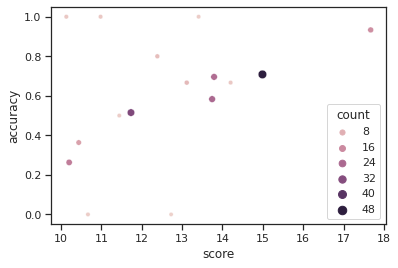

In [33]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.scatterplot(data=df_error, x="score", y="accuracy", hue="count", size="count")

## Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05